## Metaflow for Notebook Users


| _Estimated time to complete: 15 minutes_

Metaflow is a human-friendly Python/R library that helps data scientists and engineers build and manage real-life data science projects. Metaflow helps you:
- track and tie versioned data and model artifacts back to the original source code 
- manage dependencies as part of the pipeline 
- work seamlessly with your choice of distributed compute

**Navigate through the tutorial at your own pace with direct links to each section:**

| Resource                 | What you'll learn |
| :------------------------ | :------------------|
| **[Core Metaflow Concepts](http://localhost:8888/notebooks/metaflow-nb-users.ipynb#101-Metaflow-Concepts---Introduction-to-the-Flow)**   | Represent your machine learning workflows in a structured, reproducible way through the foundational architecture of a Metaflow Flow. |
| **[Classifier Model — Metaflow](http://localhost:8888/notebooks/metaflow-nb-users.ipynb#Converting-your-notebook-into-a-Metaflow-Flow)**   | Construct an image classification pipeline using Metaflow’s dataflow paradigm that is easy to iterate on and debug while being simple to deploy to production. This Flow can be optimized to re-use external modules and manage compute and dependencies for each step. |
| **[Inspecting Metaflow Flows and Runs](http://localhost:8888/notebooks/metaflow-nb-users.ipynb#Inspecting-Metaflow-Flows,-Runs,-and-Steps)**   | Visualize and test model performance by retrieving already-saved metadata artifacts like saved models, parameters, and run times from previous runs (executions) of the Flow. Test different parameters using simple command line arguments and compare results.|
| **[Appendix: Classifier Model —  Notebook & Additional Metaflow Resources](http://localhost:8888/notebooks/metaflow-nb-users.ipynb#Appendix)** | See the original notebook ‘version’ of the image classifier model. Access Additional resources on Metaflow functionality|

## Pre-requisite: Installing Metaflow
On your local or remote server, you can easily install metaflow by simply running:

In [ ]:
! pip install metaflow 

or if you already have Metaflow installed and need to upgrade, run:

In [ ]:
! pip install -upgrade metaflow

## Core Metaflow Concepts - Introduction to the Flow

Metaflow follows the [dataflow paradigm](https://en.wikipedia.org/wiki/Dataflow) which models a program as a directed graph of operations. The key concepts to keep in mind are:

- **Flow:** the graph of operations
- **Step:** the operations; nodes of the graph
- **Transitions:** edges between the operations (nodes) of the graph

Metaflow supports three types of transitions: linear, branch, and foreach. The “helloworld” example below and the classifier model we’ll be building in this tutorial are both linear flows. You can read more about each transition type in the Metaflow documentation [here](https://docs.metaflow.org/metaflow/basics). 

Each flow must have a ‘start’ step as the first step and an ‘end’ step as the last step. Between each step, there should be a reference to the next step. The example below has three steps: start, a, and end. To transition between the start and a step, the last line of the start step is `self.next(self.a)`. You can read more about the purpose behind the Python self convention [here](https://stackoverflow.com/questions/2709821/what-is-the-purpose-of-the-word-self).

In [67]:
%%writefile metaflow101.py

from metaflow import FlowSpec, step

class LinearFlow(FlowSpec):

    @step
    def start(self):
        self.my_var = 'hello world'
        self.next(self.a)

    @step
    def a(self):
        print('the data artifact is: %s' % self.my_var)
        self.next(self.end)

    @step
    def end(self):
        print('the data artifact is still: %s' % self.my_var)

if __name__ == '__main__':
    LinearFlow()

Overwriting metaflow101.py


As we construct our flow, we may want to store key elements of our code and data, such as parameters, metrics, and the model itself, so that we can access them later. Metaflow automatically tracks all of these artifacts as part of its metadata service, but can store them locally if configured to do so.

If you do have AWS configured, but would like to execute the run and have those artifacts stored locally, set the directory for the metadata at the top of this notebook, like so:
```
import os
os.chdir('/your/metaflow/directory')
```

and add these command line arguments when running your Flow:

```
!python [rest of command] --datastore=local --metadata=local run
```

In [ ]:
!python metaflow101.py run

**Expected Output (if locally run):**

You can see key pieces of information about the console output: each line is prefixed with an identifier like 16348.../start/1 (pid 12345). Here, the first element (16348…) is the **run id**, start is the **step name**, and 12345 is the **task id**. This information is useful for debugging failed flows and inspecting the results from particular flows and tasks, which we’ll tackle as the last step of this tutorial. 

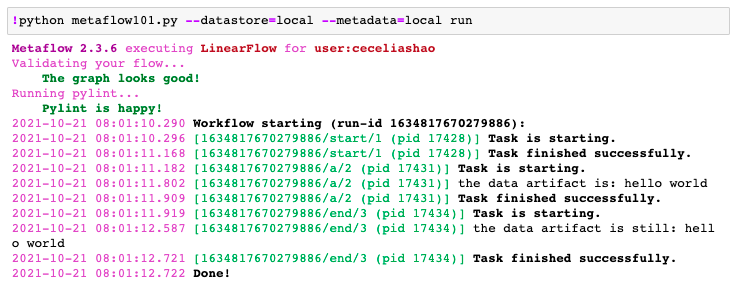

## Converting your notebook into a Metaflow Flow
We'll go through building our Metaflow flow "step" by "step" by converting the classifier from the notebook format to a flow. 

The steps for our model are: 
- **Data processing:** Download and preprocess the CIFAR10 dataset
- **Define our model:** Set out model architecture layer by layer
- **Train our model:** Train our model on the training set 
- **Test on test:** Test the model on the test set

If you want to see the notebook version of the model pipeline, you can go to the Appendix [here](http://localhost:8888/notebooks/metaflow-nb-users.ipynb#Appendix) or see the original [Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

Before we dive into our classifier model Metaflow flow, here are some best practices and helpful context for developing your flow:
#### 1. Tracking important artifacts 
As we construct our Flow, we want to store key elements of our code and data, such as parameters, metrics, and the model itself, so that we can access them later and document what we used for a specific iteration of our experiment. 

Again, Metaflow automatically tracks all of these artifacts as part of its metadata service so that all instance variables — specified using the `self.x` nomenclature — used in the step code become data artifacts that are persisted automatically.

If no AWS configuration is set, then your datastore and metadata will default to your local machine. 

#### 2. Dependency management

There are multiple approaches to managing dependencies: setting up virtual environments (through `venv`), using conda, or using docker images just to mention a few options. Metaflow works with all these different approaches and specifically uses conda behind the scenes of [the `@conda` decorator.](https://docs.metaflow.org/metaflow/dependencies#managing-dependencies-with-conda-decorator)

You can easily use pip (or conda) to install metaflow and then use `@conda` decorator to execute your metaflow steps within specific conda environments. Using metaflow's dependency management feature, you can designate specific or different versions of packages for each step (if desired).

#### 3. Organizing imports
Since your script will run top-down, consider where you want to place your imports. If you put your imports at the very top of the script before using the `@conda` decorator, the libraries' versions may differ from the version you intend to use through that conda environment. 

#### 4. Organizing the steps of your Flow
Within the flow, you’ll be implementing steps as methods that are decorated with the `@step` decorator. A step is the smallest resumable unit of computation. Beyond steps, a Flow can also define other attributes such as parameters.

#### 5. Writing reusable, modular code
We’ll be splitting some key steps from our flow out into separate modules and importing them into our step. This makes the Metaflow flow code more legible and helps modularize our pipeline, which comes in handy if a collaborator wants to use the same model definition for another pipeline or if we want to switch out our model for another and compare performance.

## Step 1: Access Data
We are going to take our notebook cells (A + B) for reading in the CIFAR dataset and doing the necessary pre-processing. Then we will convert that code into the first step of our Metaflow Flow, which we'll title `ClassifierFlow`.

Before our first `start` @step, note how we defined our different parameters. Closer to the end of the tutorial, we’ll test different values for these parameters to see if we can improve our model’s performance.


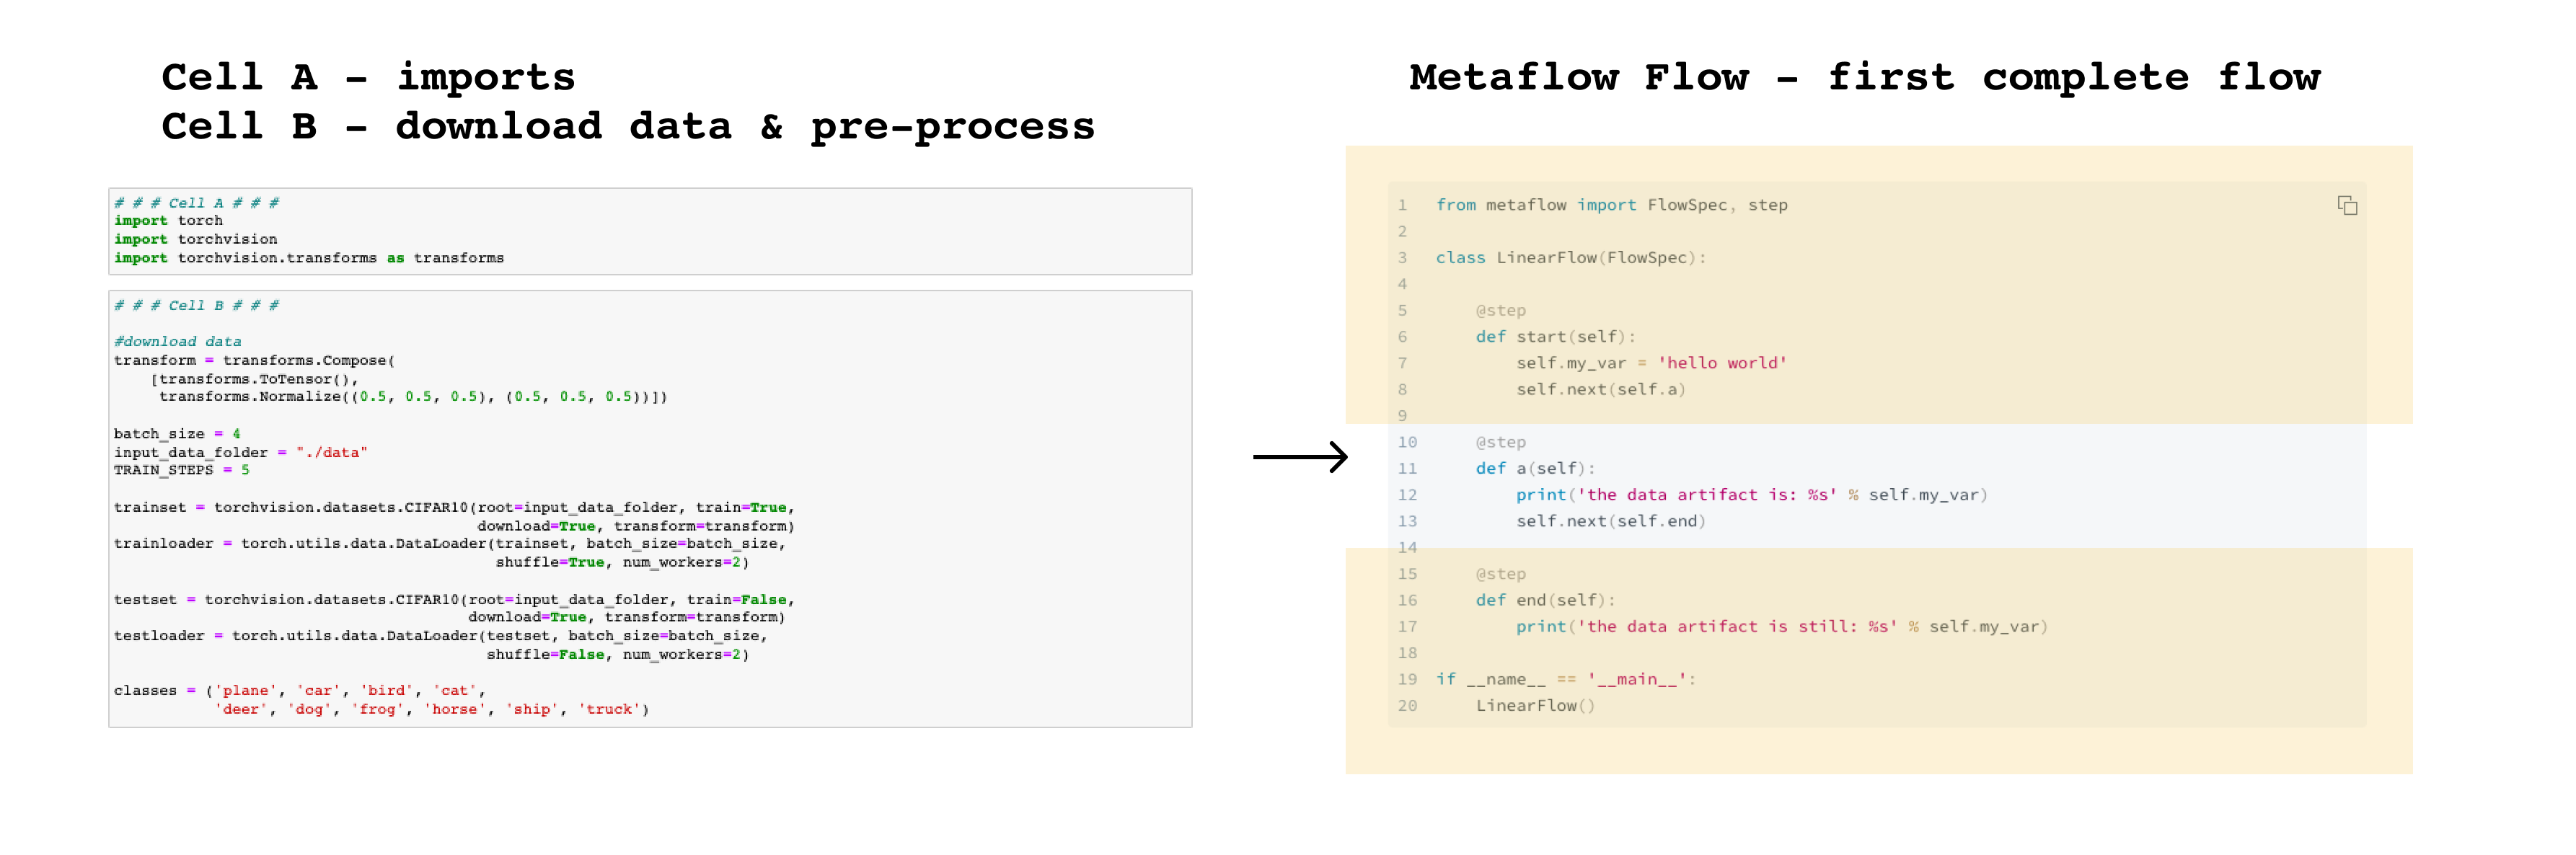

In [ ]:
%%writefile cifar_classifier.py
## `%%writefile` will create the `cifar_classifier.py` file with the following contents into your current local directory

# import key modules from Metaflow
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:yourdesiredusernamehere')

class ClassifierFlow(FlowSpec):

    """
    define parameters
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        to save or reference variables out of this step, use `self.`
        we're going to instantiate our data loaders (trainloader, testloader) in the next two (2) steps
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        
        # reference next step - in this case, it's the last (end) step
        self.next(self.end)
    
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

**Expected Output:**

`Overwriting cifar_classifier.py`

Now try running the script you just made using this command:

In [ ]:
!python cifar_classifier.py run

**Expected Output:**

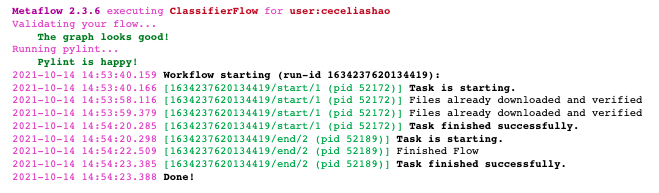


## Step 2: Define Model 
Now we are going to take our notebook cells (C) for defining our model and add it into our flow. We'll take a different approach with this step and create a separate module for model definition. This approach of splitting out a distinct module has two primary benefits:

1. makes the pipeline more modular. If a teammate wanted to use the same model definition, they can leverage it easily.
2. makes the metaflow flow more legible. 

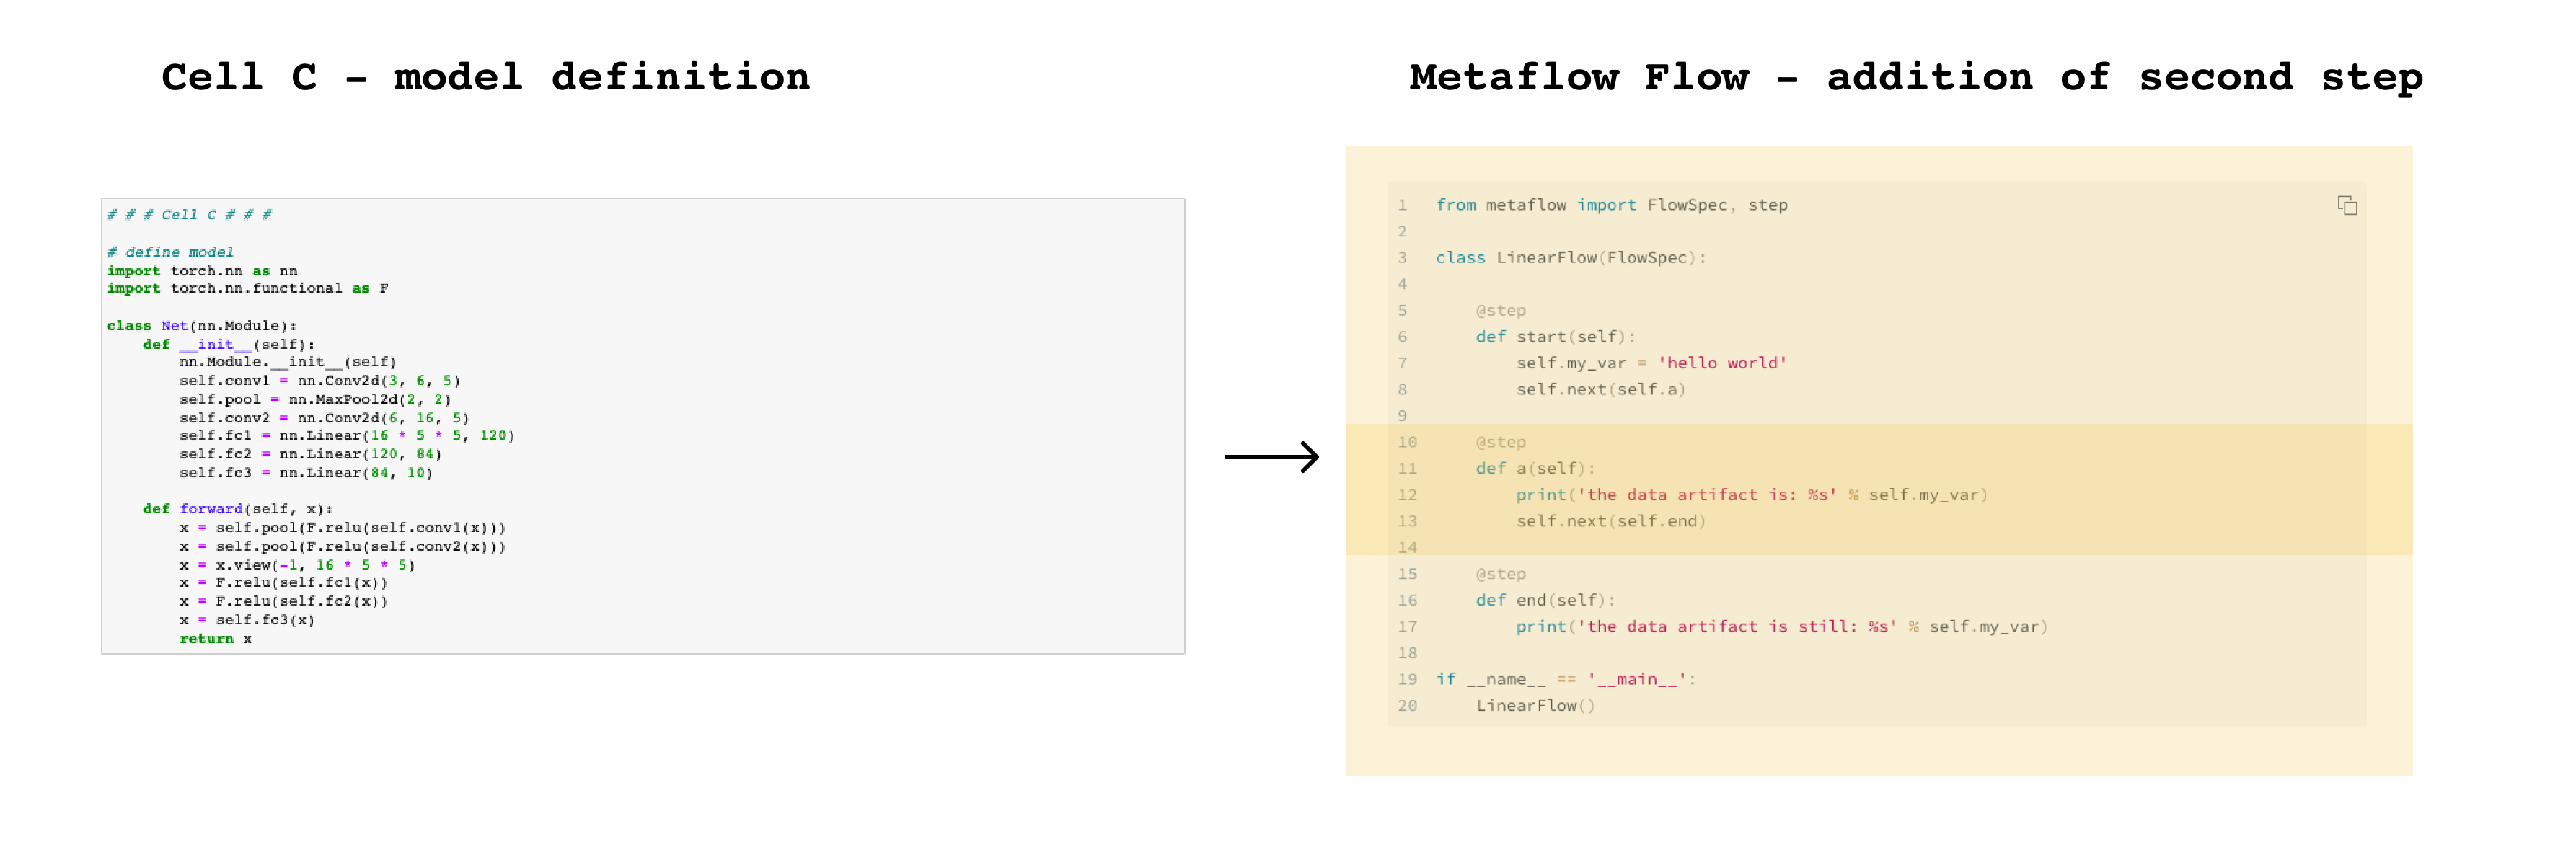

The first we'll do is use the same %%writefile magic to create the separate model definition module, like so:

In [ ]:
%%writefile classifier_model_definition.py

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):

        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Once you have the `classifier_model_definition.py` in your directory, import the model into the 'define_model' step in the Metaflow flow.

In [ ]:
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        #print to see the structure of the model - this is optional
        print(self.net)
        
        self.next(self.end)

Once you have the complete flow, trying running it again:

In [ ]:
!python cifar_classifier.py run

**Expected Output:**

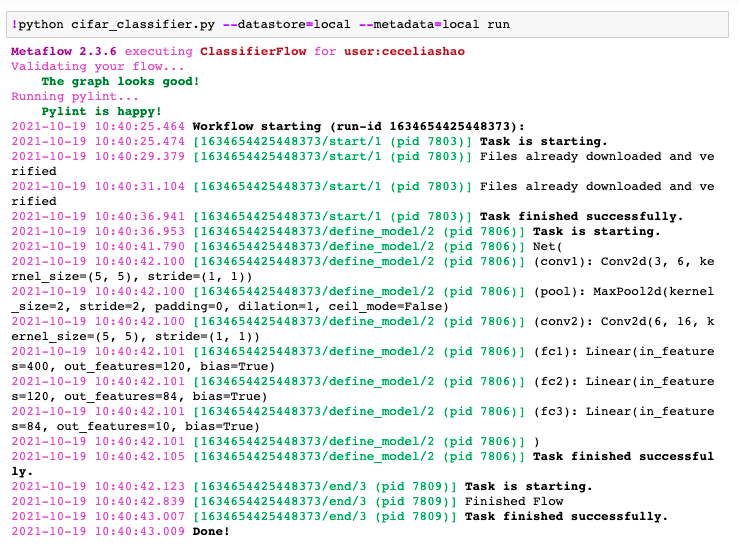

## Step 3: Train Model
Next, we are going to take our notebook cells (D + E) and add those steps for defining the model's optimization critera with a starting set of hyperparameters and training the model to the Flow.

In [110]:
%%writefile cifar_classifier.py
## running this cell after we've created our first flow will override the existing cifar_classifier.py script from above

# import key modules 
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:yourdesirednamespacehere')

class ClassifierFlow(FlowSpec):
    
    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    epochs = Parameter('epochs', default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        To save or reference variables out of this step, use `self.`
        we're going to instantiate our data loaders (trainloader, testloader) in the next two (2) steps 
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        
        # reference next step - in this case, it's our second (define_model) step
        self.next(self.define_model)
        
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        self.next(self.train_model)
        
    @step
    def train_model(self):
        
        import torch
        import torch.nn as nn
        import torch.optim as optim
        
        trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=self.num_workers)
    
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        
        self.net.train()
        
        self.running_loss = 0.0
        self.running_loss_history = []
        printfreq = 1000
        
        #set model to the right mode
        self.net.train()
        
        for epoch in range(self.epochs):  # loop over the dataset multiple times
            
            for i, data in enumerate(trainloader):
                # get the inputs
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                self.running_loss += loss.item()
                
                if i % printfreq == printfreq-1:
                    print(self.epochs, i+1, self.running_loss / printfreq)
                    epoch_loss = self.running_loss / printfreq
                    self.running_loss_history.append(epoch_loss)
                    self.running_loss = 0.0
            
        print('Finished Training')
        
        self.next(self.end)
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

Overwriting cifar_classifier.py


In [ ]:
!python cifar_classifier.py

## Step 4: Test Model
Next, we are going to take our notebook cell (F) which tests our model on the set of test data we held out from the CIFAR-10 dataset and add as the second-to-last step of our flow. Remember, the last step of the flow needs to be the `end` step.

This is the complete Flow for our ClassifierFlow:

In [122]:
%%writefile cifar_classifier.py
## running this cell after we've created our first flow will override the existing cifar_classifier.py script from above

# import key modules 
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:yourdesirednamespacehere')

class ClassifierFlow(FlowSpec):
    
    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    epochs = Parameter('epochs', default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        To save or reference variables out of this step, use `self.`  
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        
        # reference next step - in this case, it's our second (define_model) step
        self.next(self.define_model)
        
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        self.next(self.train_model)
        
    @step
    def train_model(self):
        
        import torch
        import torch.nn as nn
        import torch.optim as optim
    
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        
        trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=self.num_workers)
        
        self.running_loss = 0.0
        self.running_loss_history = []
        printfreq = 1000
        
        self.net.train()
        
        for epoch in range(self.epochs):  # loop over the dataset multiple times
            
            for i, data in enumerate(trainloader):
                # get the inputs
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                self.outputs = self.net(inputs)
                loss = criterion(self.outputs, labels)
                loss.backward()
                optimizer.step()
                
                self.running_loss += loss.item()
                
                if i % printfreq == printfreq-1:
                    print(self.epochs, i+1, self.running_loss / printfreq)
                    epoch_loss = self.running_loss / printfreq
                    self.running_loss_history.append(epoch_loss)
                    self.running_loss = 0.0
            
        print('Finished Training')
        
        self.next(self.model_test)
    
    @step
    def model_test(self):
        
        import torch
        
        correct = 0
        total = 0

        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                         shuffle=False, num_workers=self.num_workers)
        self.net.eval()
        
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                accuracy = (100 * correct)/total

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        
        self.next(self.end)
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

Overwriting cifar_classifier.py


In [123]:
!python cifar_classifier.py --no-pylint --datastore=local --metadata=local run

Metaflow 2.3.6 executing ClassifierFlow for user:ceceliashao
Validating your flow...
    The graph looks good!
2021-11-17 14:52:01.950 Workflow starting (run-id 1637178721930117):
2021-11-17 14:52:01.958 [1637178721930117/start/1 (pid 41472)] Task is starting.
2021-11-17 14:52:06.893 [1637178721930117/start/1 (pid 41472)] Files already downloaded and verified
2021-11-17 14:52:08.285 [1637178721930117/start/1 (pid 41472)] Files already downloaded and verified
2021-11-17 14:52:12.429 [1637178721930117/start/1 (pid 41472)] Task finished successfully.
2021-11-17 14:52:12.438 [1637178721930117/define_model/2 (pid 41475)] Task is starting.
2021-11-17 14:52:16.507 [1637178721930117/define_model/2 (pid 41475)] Task finished successfully.
2021-11-17 14:52:16.520 [1637178721930117/train_model/3 (pid 41478)] Task is starting.
2021-11-17 14:52:43.469 [1637178721930117/train_model/3 (pid 41478)] 5 1000 2.2983828971385956
2021-11-17 14:52:50.725 [1637178721930117/train_model/3 (pid 41478)] 5 2000 2.

2021-11-17 15:01:54.361 [1637178721930117/train_model/3 (pid 41478)] 5 11000 1.0230072688492946
2021-11-17 15:02:04.057 [1637178721930117/train_model/3 (pid 41478)] 5 12000 1.0092300161318855
2021-11-17 15:02:17.156 [1637178721930117/train_model/3 (pid 41478)] Finished Training
2021-11-17 15:02:22.994 [1637178721930117/train_model/3 (pid 41478)] Task finished successfully.
2021-11-17 15:02:23.008 [1637178721930117/model_test/4 (pid 41522)] Task is starting.
2021-11-17 15:03:02.418 [1637178721930117/model_test/4 (pid 41522)] Accuracy of the network on the 10000 test images: 60 %
2021-11-17 15:03:05.161 [1637178721930117/model_test/4 (pid 41522)] Task finished successfully.
2021-11-17 15:03:05.172 [1637178721930117/end/5 (pid 41530)] Task is starting.
2021-11-17 15:03:06.347 [1637178721930117/end/5 (pid 41530)] Finished Flow
2021-11-17 15:03:06.519 [1637178721930117/end/5 (pid 41530)] Task finished successfully.
2021-11-17 15:03:06.521 Done!


**Expected Output:**

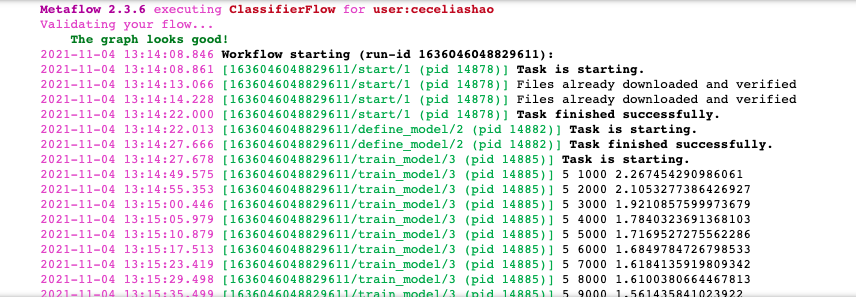


## Inspecting Metaflow Flows, Runs, and Steps

It's useful to look back at the results and artifacts from our runs so we can compare performance between runs and create visualizations to include in a presentation. These artifacts are the variables that we set in our flow (net, classes, trainset, testset, and parameters such as batch_size, etc...). Remember: a 'run' is a single execution of our flow, the ClassifierFlow.

In this part of the tutorial, we'll go through how to use Metaflow's client API to:
- Obtain a sample prediction using saved model
- Visualize model metrics across two different runs 
- Identify failed runs and see their stderr/stdout to get the error message
- Track how long a run took to complete


For more details on the client API, refer to [this section of the Metaflow documentation](https://docs.metaflow.org/metaflow/client#properties-related-to-tasks).

### See what artifacts are saved with Metaflow

In [40]:
# import metaflow objects from the metaflow package 
from metaflow import Flow, Run, Step, Task

# set the flow to our ClassifierFlow
flow = Flow('ClassifierFlow')

# set run to a specific run of the ClassifierFlow
# alt if you want to find the latest run: run = Run('ClassifierFlow').latest_run
run = Run('ClassifierFlow/1636047165358437')

# fetch value of running_loss from the task that executed the train_model step of this particular run of the ClassifierFlow
step = Step('ClassifierFlow/1636047165358437/train_model')
task = Task('ClassifierFlow/1636047165358437/train_model/3')

# see what artifacts are available 
artifact_options = task.data

print(artifact_options)

<MetaflowData: trainset, outputs, epochs, net, classes, name, running_loss, testloader, input_data_folder, testset, num_workers, train_steps, running_loss_history, trainloader, transform, batch_size>


Metaflow helps with saving and retrieving models easily. Models can take a long time to train, so saving them after they are done is good to avoid retraining them. You'll also need a way to reload them.

In [90]:
print(task.data.net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Sample Prediction

In [13]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels): 
    img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    np_img = img_grid.numpy().transpose(1,2,0)  
    plt.imshow(np_img)
    
d_class2idx = task.data.trainset.class_to_idx
d_idx2class = dict(zip(d_class2idx.values(),d_class2idx.keys()))

  cat  ship  ship airplane


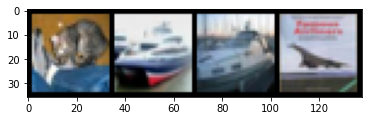

In [14]:
dataiter = iter(task.data.testloader)
images, labels = dataiter.next()
plot_images(images,labels)
print(' '.join('%5s' % d_idx2class[int(labels[j])]for j in range(len(images))))

horse horse  deer   cat


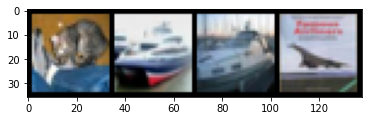

In [22]:
# see what our model predicted for these images
preds = task.data.outputs.argmax(dim=1)
plot_images(images,preds)
print(' '.join('%5s' % d_idx2class[int(preds[j])]for j in range(len(images))))

### Visualizing Loss of Different Runs 

In [23]:
print(task.data.running_loss_history)

[2.2973669261932375, 2.0914500812888144, 1.892047703742981, 1.7857110579609872, 1.6873814718127251, 1.6333325982391835, 1.5878701083660125, 1.5611352374255658, 1.544443499803543, 1.4943681494891643, 1.4489080523848534, 1.4550008589923382, 2.1449921351671217, 1.398619171500206, 1.3815477105081082, 1.3978364781737327, 1.3334751176983117, 1.371541689902544, 1.3171276968717576, 1.299949591487646, 1.3158408140093087, 1.3110123582482338, 1.2971372207552194, 1.3201183170974256, 1.8877267751023172, 1.23184187489748, 1.1940778965130447, 1.2147030209004879, 1.2103738120645284, 1.2110802973508834, 1.2384506600946188, 1.2528937153741717, 1.231643863119185, 1.198210556924343, 1.1930131382606923, 1.2070368525981903, 1.7154968190044164, 1.1401604847311975, 1.150867325142026, 1.1152514333575965, 1.1404827445670962, 1.1504043089821934, 1.162534367889166, 1.1161865368187427, 1.1340856870114804, 1.1593108439221977, 1.1192011545971037, 1.1132461974769832, 1.5792550093047322, 1.0520180251337587, 1.07045332

We set all of our parameters at the top of the flow. Let's try experimenting with different values for some of our parameters to see if we can improve our model's performance. Try running the flow with a different value for a parameter. In this example, we'll train the model for more epochs (10 as opposed to 5) and see if we can improve the model's performance:

```
![rest of command line] --epochs 10
```

In [24]:
!python cifar_classifier.py --no-pylint --datastore=local --metadata=local run --epochs 10 | head -20

Metaflow 2.3.6 executing ClassifierFlow for user:ceceliashao
Validating your flow...
    The graph looks good!
2021-11-04 13:47:14.031 Workflow starting (run-id 1636048034016421):
2021-11-04 13:47:14.039 [1636048034016421/start/1 (pid 15114)] Task is starting.
2021-11-04 13:47:18.451 [1636048034016421/start/1 (pid 15114)] Files already downloaded and verified
2021-11-04 13:47:19.797 [1636048034016421/start/1 (pid 15114)] Files already downloaded and verified
2021-11-04 13:47:28.042 [1636048034016421/start/1 (pid 15114)] Task finished successfully.
2021-11-04 13:47:28.060 [1636048034016421/define_model/2 (pid 15118)] Task is starting.
2021-11-04 13:47:32.470 [1636048034016421/define_model/2 (pid 15118)] Task finished successfully.
2021-11-04 13:47:32.478 [1636048034016421/train_model/3 (pid 15121)] Task is starting.
2021-11-04 13:47:50.242 [1636048034016421/train_model/3 (pid 15121)] 10 1000 2.300862819671631
2021-11-04 13:47:54.737 [1636048034016421/train_model/3 (pid 15121)] 10 2000 2

2021-11-04 13:57:43.010 [1636048034016421/train_model/3 (pid 15121)] 10 10000 1.0453744558393956
2021-11-04 13:57:48.219 [1636048034016421/train_model/3 (pid 15121)] 10 11000 1.0277542722560464
2021-11-04 13:57:54.716 [1636048034016421/train_model/3 (pid 15121)] 10 12000 1.012688813585788
2021-11-04 13:58:23.501 [1636048034016421/train_model/3 (pid 15121)] 10 1000 1.4487332488591782
2021-11-04 13:58:28.122 [1636048034016421/train_model/3 (pid 15121)] 10 2000 0.9675999570386484
2021-11-04 13:58:32.719 [1636048034016421/train_model/3 (pid 15121)] 10 3000 0.9286299214586615
2021-11-04 13:58:37.256 [1636048034016421/train_model/3 (pid 15121)] 10 4000 0.9502574770860374
2021-11-04 13:58:41.882 [1636048034016421/train_model/3 (pid 15121)] 10 5000 0.9860427791588008
2021-11-04 13:58:46.414 [1636048034016421/train_model/3 (pid 15121)] 10 6000 0.9835314346142113
2021-11-04 13:58:51.006 [1636048034016421/train_model/3 (pid 15121)] 10 7000 0.9405565452706068
2021-11-04 13:58:55.687 [1636048034016

2021-11-04 14:13:58.312 [1636048034016421/model_test/4 (pid 15264)] Accuracy of the network on the 10000 test images: 63 %
2021-11-04 14:14:00.965 [1636048034016421/model_test/4 (pid 15264)] Task finished successfully.
2021-11-04 14:14:00.976 [1636048034016421/end/5 (pid 15272)] Task is starting.
2021-11-04 14:14:01.932 [1636048034016421/end/5 (pid 15272)] Finished Flow
2021-11-04 14:14:02.085 [1636048034016421/end/5 (pid 15272)] Task finished successfully.
2021-11-04 14:14:02.086 Done!


In [26]:
flow2 = Flow('ClassifierFlow')
run2 = Run('ClassifierFlow/1636048034016421/')
task2 = Task('ClassifierFlow/1636048034016421/train_model/3')
artifact_options = task2.data

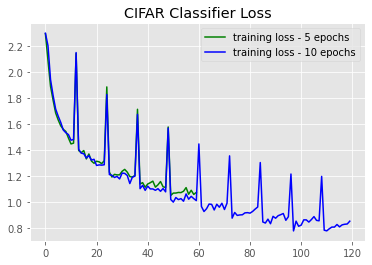

In [29]:
import matplotlib as plt
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.plot(task.data.running_loss_history, color = "green", label='training loss - 5 epochs')
plt.plot(task2.data.running_loss_history, color = "blue", label='training loss - 10 epochs')
plt.legend()
plt.title("CIFAR Classifier Loss")
plt.show()

From the visualization of our training loss, we can see that there’s value in training our model for more epochs. You can try other techniques to optimize the model such as using other optimizer algorithms, adjusting the data preprocessing, or changing the model architecture (or even bringing in a pre-trained model). 

### Find Run Details (Failed Runs, Runs with a specific tag, Run elapsed time)

In [311]:
failed_runs = []

for run in flow.runs():
    if run.successful == False:
        failed_runs.append(run.id)
        
print(failed_runs)

['1635344770591829', '1635180749259214', '1634920159978338', '1634667224013711', '1634664034189717', '1634663095454660', '1634657720226454', '1634656896601553', '1634656685142746', '1634656266814032', '1634655902772844', '1634655374037850', '1634653534570426', '1634653083727613', '1634643010894173', '1634641999887830', '1634604364403885', '1634604307379663', '1634604120162245', '1634604015168167', '1634603912469698', '1634603558001284', '1634603464250126', '1634603381722201', '1634603347527935', '1634603046387332', '1634571007458805', '1634570888007643']
[Run('ClassifierFlow/1635344946724667'), Run('ClassifierFlow/1635344770591829'), Run('ClassifierFlow/1635182795861388'), Run('ClassifierFlow/1635180996530732'), Run('ClassifierFlow/1635180749259214')]


In [313]:
# if you used tags to organize your runs
# docs link: https://docs.metaflow.org/metaflow/tagging#tagging
run_A_runs = list(flow.runs('run_A'))

print(run_A_runs)

[Run('ClassifierFlow/1635344946724667'), Run('ClassifierFlow/1635344770591829'), Run('ClassifierFlow/1635182795861388'), Run('ClassifierFlow/1635180996530732'), Run('ClassifierFlow/1635180749259214')]


In [306]:
# for failed runs, find the step that those runs failed at plus the stdout 
for run in flow.runs():
    if run.successful == False:
        print(f"failed run id:{run.id}")
        # iterate through steps and find the one that failed
        for step in run.steps():
            if not step.task.successful:
                print(step.task.stderr)
                print(step.task.stdout)

failed run id:1635344770591829
<flow ClassifierFlow step start> failed:
    Internal error
Traceback (most recent call last):
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/metaflow/cli.py", line 1007, in main
    start(auto_envvar_prefix='METAFLOW', obj=state)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1137, in __call__
    return self.main(args, kwargs)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1062, in main
    rv = self.invoke(ctx)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1668, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, ctx.params)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 763, in invoke
    return __callback(args, kwargs)

failed run id:1634656896601553
<flow ClassifierFlow step train_model> failed:
    Internal error
Traceback (most recent call last):
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/metaflow/cli.py", line 1007, in main
    start(auto_envvar_prefix='METAFLOW', obj=state)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1137, in __call__
    return self.main(args, kwargs)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1062, in main
    rv = self.invoke(ctx)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1668, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, ctx.params)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 763, in invoke
    return __callback(args, k


failed run id:1634641999887830
<flow ClassifierFlow step define_model> failed:
    Internal error
Traceback (most recent call last):
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/metaflow/cli.py", line 1007, in main
    start(auto_envvar_prefix='METAFLOW', obj=state)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1137, in __call__
    return self.main(args, kwargs)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1062, in main
    rv = self.invoke(ctx)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1668, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, ctx.params)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 763, in invoke
    return __callback(args,

<flow ClassifierFlow step define_model> failed:
    Internal error
Traceback (most recent call last):
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/metaflow/cli.py", line 1007, in main
    start(auto_envvar_prefix='METAFLOW', obj=state)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1137, in __call__
    return self.main(args, kwargs)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1062, in main
    rv = self.invoke(ctx)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1668, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, ctx.params)
  File "/Users/ceceliashao/miniconda3/lib/python3.9/site-packages/click/core.py", line 763, in invoke
    return __callback(args, kwargs)
  File "/Users/cecelias

In [390]:
# calculating how long the run took to complete
# for this flow + run, expect around 8 minutes and 30 seconds

def run_time(start, end):
    start = run.created_at
    end = run.finished_at
    FMT = "%Y-%m-%dT%H:%M:%SZ"
    tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
    print(tdelta)

run_time(run.created_at, run.finished_at)

0:08:38


## Scalability with ease 

Metaflow provides a set of easy-to-use tools that help you to make your code scalable depending on your specific needs. Metaflow integrates with Batch from AWSBatch to request a larger instance to run your step as well as use it to parallelize your steps over multiple instances. You can read the full Metaflow documentation on [Scaling Up and Out](https://docs.metaflow.org/metaflow/scaling)

In the Flow we made together, we can add a @batch or @kubernetes decorator before the steps that we want to scale up for (namely our training step). The main benefit of using the @batch or @kubernetes decorators is that you can selectively run some steps locally and some on the resource type of your choice.

In the flow we made together, we can add a `@batch` or `@kubernetes`decorator before the steps that we want to scale up for (namely our training step). The main benefit of batch is that you can selectively run some steps locally and some on the compute of your choice.


```
@batch(memory=60000, cpu=1, image=”pytorch/pytorch”)
@step
    def train_model(self):
    
```


To run all your steps with Batch or Kubernetes, using the `--with batch` or  `--with kubernetes` options will instruct Metaflow to run all tasks as separate AWS Batch or Kubernetes jobs. This has the same effect as adding the @batch or @kubernetes decorator to all steps in the code. Here’s an example with AWS Batch:

```
! python cifar_classifier.py run -- with batch
```

### SUMMARY

< insert summary here >


## Appendix

## More Resources on Metaflow:
To explore Metaflow further, check out these resources:

- [Join the Metaflow Slack](https://join.slack.com/t/outerbounds-community/shared_invite/zt-ov7l57er-nTG~HfoBOYufTp~okKohSg)
- [Read the Metaflow documentation](https://docs.metaflow.org/)
- [Try other tutorials](https://docs.metaflow.org/getting-started/tutorials) — once you install metaflow, you can run `metaflow tutorials pull` which will create a directory ‘metaflow-tutorials’ with a subdirectory for each tutorial
- [Learn about Metaflow’s new monitoring GUI](https://netflixtechblog.com/open-sourcing-a-monitoring-gui-for-metaflow-75ff465f0d60)

## Notebook Version - Classifier 
In this tutorial, we will build a simple machine learning workflow for training a classifier on CIFAR10 dataset using Pytorch. This content is taken from the PyTorch tutorial ["Training a Classifier"](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). This process and workflow of converting code into a Metaflow format is generalizable to many other workflows and libraries outside of image recognition using PyTorch. 

<br>

Install Pytorch through Anaconda [here](https://pytorch.org/get-started/locally)

Again, the steps for our model pipeline are: 
1. **data-processing**: Download and preprocess the CIFAR10 dataset
2. **train**: Train our model
3. **test-on-test**: Test the model on the test set
4. **evaluate-model**: Test the model performance on the whole dataset

In [339]:
# # # Cell A # # # 
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# # # Cell B # # # 

#download data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
input_data_folder = "./data"
TRAIN_STEPS = 5

trainset = torchvision.datasets.CIFAR10(root=input_data_folder, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=input_data_folder, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# # # Cell C # # # 

# define model 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# # # Cell D # # #

# Define loss func and optimizer

import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# # # Cell E # # # 

# train model

TRAIN_STEPS = 5

for epoch in range(TRAIN_STEPS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
! pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# test on snippet of test data 
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# # # Cell F # # # 

correct = 0
total = 0

#test on whole dataset 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))